In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.collections import LineCollection
import seaborn as sns
import sys
from collections import defaultdict

In [17]:
algs = ["ac-normal", "ac-scaled", "ac-parl2", 
        "sarsa-normal", "sarsa-scaled", "sarsa-parl2",
        "qlambda-normal", "qlambda-scaled", "q-parl2",
        "nactd", "ppo"
]
envs = ["acrobot_d", "cartpole_d", "mntcar_d",
        "chain10d", "chain10s", 
        "chain50d", "chain50s", 
        "gw10d", "gw10s", "gw5d", "gw5s", 
        "pbbox", "pbempt", "pbmed", "pbsingle",
]
anames = ['AC', "AC-s", "AC-parl2", 
          r'Sarsa($\lambda$)', r'Sarsa($\lambda$)-s', r'Sarsa-Parl2',
          r'Q($\lambda$)', r'Q($\lambda$)-s', r'Q-Parl2',
          'NAC-TD', 'PPO']
enames = ['Acrobot', "Cart-Pole", 'Mountain Car',
          "Chain 10 Deterministic", "Chain 10 Stochastic", 
          "Chain 50 Deterministic", "Chain 50 Stochastic", 
          'Gridworld 10 Deterministic', 'Gridworld 10 Stochastic', 
          'Gridworld 5 Deterministic', 'Gridworld 5 Stochastic', 
          'Pinball Box', 'Pinball Empty', 
          'Pinball Medium', 'Pinball Single']


In [33]:
agg_dir = "./data/"
agg_PBP = pd.read_csv(agg_dir + "agg_pbp.csv")
agg_PBPt = pd.read_csv(agg_dir + "agg_pbpt.csv")
agg_BS = pd.read_csv(agg_dir + "agg_bs.csv") 

In [34]:
agg_PBP

,aname,score,score_low,score_high,rank,rank_low,rank_high
0,sarsa-parl2,0.462302,0.390445,0.553741,1,2,1
1,q-parl2,0.452319,0.378233,0.563269,2,2,1
2,ac-parl2,0.157809,0.076544,0.312941,3,11,3
3,sarsa-scaled,0.093013,0.033725,0.227599,4,11,3
4,ac-scaled,0.085137,0.030509,0.214590,5,11,3
5,sarsa-normal,0.083090,0.028978,0.201945,6,11,3
6,ac-normal,0.078468,0.027506,0.203338,7,11,3
7,qlambda-scaled,0.068869,0.023735,0.197328,8,11,3
8,qlambda-normal,0.064017,0.021448,0.178041,9,11,3
9,nactd,0.051574,0.018024,0.163611,10,11,3


In [35]:
def plot_agg(df1, df2, df3, aname, title, save=False):

    fig, axs = plt.subplots()
    axs.errorbar(aname, df1.score, yerr=(df1.score - df1.score_low, df1.score_high-df1.score), 
                 fmt='o', markersize=4, fillstyle="full",
                 markerfacecolor="black", markeredgecolor="black", 
                 ecolor="dodgerblue",
                 capthick=1.5,capsize = 6
                )
    axs.errorbar(aname, df2.score, yerr=(df2.score - df2.score_low, df2.score_high-df2.score), 
                 fmt='o', markersize=4, fillstyle="full",
                 markerfacecolor="black", markeredgecolor="black", 
                 ecolor="darkorange",
                 capthick=1.5,capsize = 6
                )
    axs.errorbar(aname, df3.score, yerr=(df3.score - df3.score_low, df3.score_high-df3.score), 
                 fmt='o', markersize=4, fillstyle="full",
                 markerfacecolor="black", markeredgecolor="black", 
                 ecolor="darkred", 
                 capthick=1.5, capsize = 6
                )
    for tick in axs.get_xticklabels():
        tick.set_rotation(45)
    axs.set_ylabel("Aggregate Score")
    custom_lines = [Line2D([], [], color="dodgerblue", marker="o", markersize=4, label="PBP"),
                    Line2D([], [], color="darkorange", markersize=4, marker="o", label="PBP-t"),
                    Line2D([], [], color="darkred", markersize=4, marker="o", label="Bootstrap")]
    axs.legend(["PBP", "PBP-t", "Bootstrap"])
    axs.set_title("Aggregate Algorithm Performance")
    fig.subplots_adjust(bottom=0.2, top=0.9)
    if save:
        pp = PdfPages(title+'.pdf')
        pp.savefig(fig)
        pp.close()
    

<IPython.core.display.Javascript object>


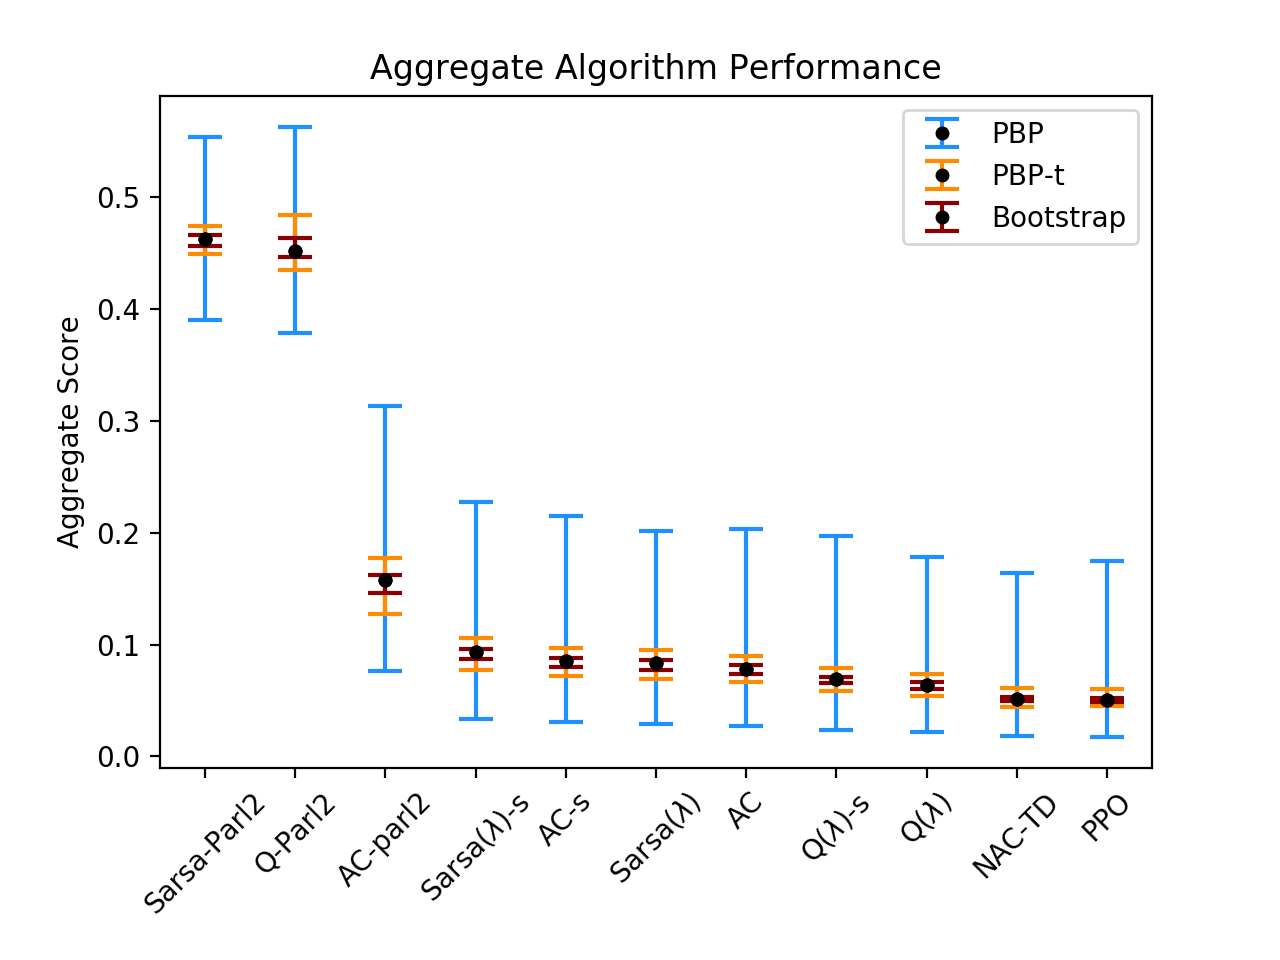

In [36]:
agg_order = [algs.index(n) for n in agg_PBP.aname]
plot_names = [anames[i] for i in agg_order]
plot_agg(agg_PBP, agg_PBPt, agg_BS, plot_names, "aggregate_perf_bounds", save=False)

In [27]:
base_dir = "data/samples"

acn_cols = ["dorder", "iorder", "full", "gamma", "lam", "palpha", "valpha", "logp", "life", "end"]
acs_cols = ["dorder", "iorder", "full", "gamma", "lam", "palpha", "valpha", "logp", "life", "end"]
acp_cols = ["dorder", "iorder", "full", "gamma", "lam", "palpha", "logp", "life", "end"]
qln_cols = ["dorder", "iorder", "full", "gamma", "lam", "eps", "qalpha", "logp", "life", "end"]
qls_cols = ["dorder", "iorder", "full", "gamma", "lam", "eps", "qalpha", "logp", "life", "end"]
qlp_cols = ["dorder", "iorder", "full", "gamma", "lam", "eps", "logp", "life", "end"]
sln_cols = ["dorder", "iorder", "full", "gamma", "lam", "eps", "qalpha", "logp", "life", "end"]
sls_cols = ["dorder", "iorder", "full", "gamma", "lam", "eps", "qalpha", "logp", "life", "end"]
slp_cols = ["dorder", "iorder", "full", "gamma", "lam", "eps", "logp", "life", "end"]
ntd_cols = ["dorder", "iorder", "full", "gamma", "lam", "palpha", "walpha", "valpha", "normw", "logp", "life", "end"]
ppo_cols = ["dorder", "iorder", "full", "gamma", "lam", "clip", "entropy", "steps", "epochs", "batch_size", "adam-eps", "alpha", "logp", "life", "end"]
alg_cols = [acn_cols, acs_cols, acp_cols, sln_cols, sls_cols, slp_cols, qln_cols, qls_cols, qlp_cols, ntd_cols, ppo_cols];

In [28]:
swps = defaultdict(dict)

for alg, acols in zip(algs, alg_cols):
    for env in envs:
        if "chain" in env or "gw" in env:
            cols = acols[3:]
        else:
            cols = acols
        path = os.path.join(base_dir, env, "allres_"+alg+".csv")
        if os.path.exists(path):
            df = pd.read_csv(path, header=None, names=cols)
            swps[alg][env] = df
        else:
            print(path, "does not exist")

In [29]:
def ECDF(D, xs):
    #Assume D is sorted   
    return np.searchsorted(D, xs, side='right') / D.shape[0]
    #return np.arange(D.shape[0])/ float(D.shape[0])
    

def DKW(ecdf, n, delta):
    eps = np.sqrt(np.log(2./delta)/(2*n))
    lower = ecdf-eps
    upper = ecdf+eps
    return np.clip(lower, a_min=0., a_max=None), np.clip(upper, a_min=None, a_max=1.)
    
def anderson_bound(D, delta, a, b):
    # assume D sorted
    # alpha is cvar threshold
    # delta is CI
    # a is the lower bound on the Data
    # b is the upper bound on the Data
    N = D.shape[0]
    eps = np.sqrt(np.log(2./delta)/(2*N))
    
    Z = np.concatenate((D, [b]))
    tmp = np.clip((np.arange(1, N+1) / N) - eps, a_min=0, a_max=None)
    upd = np.sum(np.diff(Z) * tmp)
    upper = b - upd
    
    Z = np.concatenate(([a], D))
    tmp = np.clip((np.arange(0, N) / N) + eps, a_min=None, a_max=1)
    lwd = np.sum(np.diff(Z) * tmp)
    lower = D[-1] - lwd
    
    return lower, upper

def cdf(D, xs, delta):
    # Assume D is sorted
    ecdf = ECDF(D, xs)
    lower, upper = DKW(ecdf, D.shape[0], delta)
    return ecdf, lower, upper

def comp_mean(D, delta, a, b):
    mn = D.mean()
    ml, mu = anderson_bound(D, delta, a, b)
    return mn, ml, mu
    
def comp_and_bound(D, xs, quants, alpha, delta, a, b, n, m):
    N = D.shape[0]
    
    mn, ml, mh = comp_mean(D, delta, a, b)
    
    ec, el, eh = cdf(D, xs, delta)
    
    
    mns = (mn, ml, mh)
    ecs = (ec, el, eh, xs)
    
    return mns, ecs


In [40]:
def ploticdf(mid, low, high, anames, title, ylabel, save=False):
    fig = plt.figure()
    x = np.arange(0 + 1e-3, 1., 0.001)
    plt.plot(x, np.array(mid).T, linewidth=0.5)
    for i in range(len(low)):
        plt.fill_between(x, low[i], high[i], alpha=0.4)
    if 'Car' in title:
        plt.legend(anames, loc='upper left')
    else:
        plt.legend(anames)
    plt.xlabel('Quantile')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    if save:
        pp = PdfPages(title+'.pdf')
        pp.savefig(fig)
        pp.close()
#     plt.close(fig)
    
def ploticdf_2(y, mid, low, high, anames, title, ylabel, fname, save=False):
    NUM_COLORS = len(low)
    fig, ax = plt.subplots()

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + ["darkmagenta"]
    ax.set_prop_cycle('color', colors)
    for i in range(len(low)):
        ax.plot(mid[i], y[i], linewidth=1.)
        ax.fill_betweenx(y[i], low[i], high[i], alpha=0.4)
    if 'Car' in title:
        ax.legend(anames, loc='upper left')
    else:
        ax.legend(anames, loc='lower right')
    ax.set_xlabel('probability')
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    if save:
        pp = PdfPages(fname+'.pdf')
        pp.savefig(fig)
        pp.close()
#     plt.close(fig)

def plotcdf_2(y, mid, low, high, anames, title, ylabel, fname, save=False):
    NUM_COLORS = len(low)
    fig, ax = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + ["darkmagenta"]
    ax.set_prop_cycle('color', colors)
    for i in range(len(low)):
        ax.plot(y[i], mid[i], linewidth=1.)
        ax.fill_between(y[i], low[i], high[i], alpha=0.4)
    if 'Car' in title:
        ax.legend(anames, loc='upper left')
    else:
        ax.legend(anames, loc='upper left')
    ax.set_xlabel(ylabel)
    ax.set_ylabel('probability')
    ax.set_title(title)
    if save:
        pp = PdfPages("cdf_"+fname+'.pdf')
        pp.savefig(fig)
        pp.close()
#     plt.close(fig)

In [41]:
def compstats(D, a, b, delta):
    # D is returns, [a,b] are min max possible values, delta is conf interval
    D.sort()
    Dmin = D.min()
    Dmax = D.max()
    xs = np.copy(D)
    quants = np.arange(0+1e-3, 1., 0.001)
    sizeBoot= 1000
    numBoot = 1000
    alpha = 0.5  # cvar alpha
    mns, ecs = comp_and_bound(D, xs, quants, alpha, delta, a, b, n=sizeBoot, m=numBoot)
    return mns, ecs

def make_cdf(D, a,b):
    D = np.sort(D)
    return lambda x: ECDF(D, x)

def compall(dfs, enames, algnames, delta, perf="life"):
    stats = defaultdict(dict)
    for ename in enames:
        a,b = 0,0
        rets = []
        for aname in algnames:
            ret = dfs[aname][ename].loc[:, perf].values.tolist()
            if np.any(np.isnan(ret)):
                print(aname, ename)
            rets.extend(ret)
        a = np.min(rets)
        b = np.max(rets)
        
        for aname in algnames:
            mns, ecs = compstats(dfs[aname][ename].loc[:, perf].values, a, b, delta)
            d = {}
            d['mean'] = mns[0]
            d['mean_low'] = mns[1]    # Andersons Bound
            d['mean_high'] = mns[2]   # Andersons Bound
            d['cdf'] = ecs[0]
            d['cdf_low'] = ecs[1]  # DKW
            d['cdf_high'] = ecs[2] # DKW
            d['cdf_x'] = ecs[3] # x inputs 
            d['a'] = a
            d['b'] = b
            d['cdf_fn'] = make_cdf(np.copy(ecs[3]), a,b)
            
            stats[ename][aname] = d
    return stats

In [42]:
def invcdf_stats(D, a, b, delta):
    # D is returns, [a,b] are min max possible values, delta is conf interval
    D.sort()
    Dmin = D.min()
    Dmax = D.max()
    Drange = Dmax-Dmin
    xs = np.arange(a, b+0.0000001, Drange/10000.)
    quants = np.arange(0+1e-3, 1., 0.001)
    sizeBoot= 1000
    numBoot = 1000
    alpha = 0.5  # cvar alpha
    mns, lw, up = cdf(D, xs, delta)
    return mns, lw, up, xs

In [37]:
delta_all = 0.05 / (len(envs) * len(algs))
print("num envs: ", len(envs), "num algs: ", len(algs), 1.-delta_all)
stats = compall(swps, envs, algs, delta=delta_all, perf="life")

num envs:  15 num algs:  11 0.9996969696969698


In [43]:
Dall = swps['ac-normal']['acrobot_d'].loc[:, "life"].values
D10 = Dall[np.random.choice(range(Dall.shape[0]), size=10)]
D50 = Dall[np.random.choice(range(Dall.shape[0]), size=50)]
D100 = Dall[np.random.choice(range(Dall.shape[0]), size=100)]
D1000 = Dall[np.random.choice(range(Dall.shape[0]), size=1000)]
ab_ = stats['acrobot_d']['ac-normal']['a'], stats['acrobot_d']['ac-normal']['b']

In [44]:
delta = 0.05#(0.05 / (len(tenvs)*len(talgs)))
m10 = invcdf_stats(D10, ab_[0], ab_[1], delta)
m50 = invcdf_stats(D50, ab_[0], ab_[1], delta)
m100 = invcdf_stats(D100, ab_[0], ab_[1], delta)
m1000 = invcdf_stats(D1000, ab_[0], ab_[1], delta)
m10000 = invcdf_stats(Dall, ab_[0], ab_[1], delta)

<IPython.core.display.Javascript object>


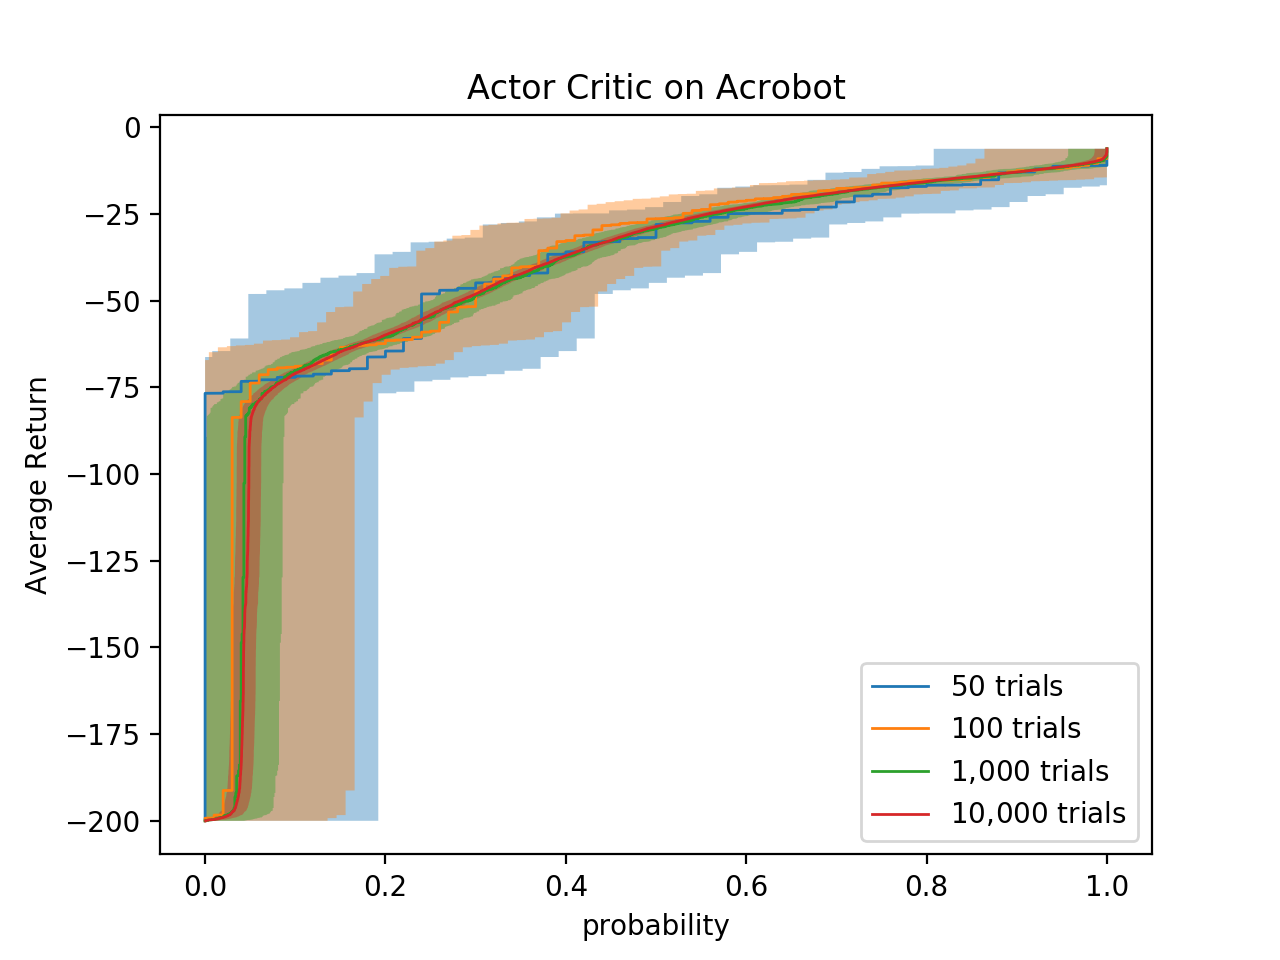

In [45]:
ms = []
ls = []
hs = []
ys = []
for m,l,h,y in [m50, m100, m1000, m10000]:
    ms.append(m)
    ls.append(l)
    hs.append(h)
    ys.append(y)
ploticdf_2(ys, ms, ls, hs, [r'$50$ trials', r'$100$ trials', r'$1,\!000$ trials', r'$10,\!000$ trials'], 
           'Actor Critic on Acrobot', 'Average Return', "cdf_bounds_acab")

In [48]:
def plotallinvCDF(stats, envs, algs, enames, anames, ylabel, base_fname, save=False):
    for i, env in enumerate(envs):
        ms, ls, hs, ys = [], [], [], []
        for alg in algs:
            ms.append(stats[env][alg]['cdf'])
            ls.append(stats[env][alg]['cdf_low'])
            hs.append(stats[env][alg]['cdf_high'])
            ys.append(stats[env][alg]['cdf_x'])
        ploticdf_2(ys, ms, ls, hs, anames, enames[i], ylabel, base_fname+enames[i].replace(" ", "_"), save=save)
        
def plotallCDF(stats, envs, algs, enames, anames, ylabel, base_fname, save=False):
    for i, env in enumerate(envs):
        ms, ls, hs, ys = [], [], [], []
        for alg in algs:
            ms.append(stats[env][alg]['cdf'])
            ls.append(stats[env][alg]['cdf_low'])
            hs.append(stats[env][alg]['cdf_high'])
            ys.append(stats[env][alg]['cdf_x'])
        plotcdf_2(ys, ms, ls, hs, anames, enames[i], ylabel, base_fname+enames[i].replace(" ", "_"), save=save)
     
        
def plotallinvCDF2(stats, envs, algs, enames, anames, ylabel, title, save=False):
    yss, mids, lows, highs = [], [], [], []
    for i, env in enumerate(envs):
        ms, ls, hs, ys = [], [], [], []
        for alg in algs:
            ms.append(stats[env][alg]['cdf'])
            ls.append(stats[env][alg]['cdf_low'])
            hs.append(stats[env][alg]['cdf_high'])
            ys.append(stats[env][alg]['cdf_x'])
        mids.append(ms)
        lows.append(ls)
        highs.append(hs)
        yss.append(ys)
    ploticdf3(yss, mids, lows, highs, anames, enames, ylabel, title, save=save)
    
def ploticdf3(yss, mids, lows, highs, anames, enames, yaxis, title, save=False):
    fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(8,8))
    
    for j in range(len(enames)):
        ys = yss[j]
        mid = mids[j]
        low = lows[j]
        high = highs[j]
        ax = axs[j//2, j%2]
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + ["darkmagenta"]
        ax.set_prop_cycle('color', colors)
        for i in range(len(low)):
            ax.plot(mid[i], ys[i], linewidth=0.5, rasterized=True)
            ax.fill_betweenx(ys[i], low[i], high[i], alpha=0.25, rasterized=True)
        ax.set_title(enames[j])
    leg = axs[1,0].legend(anames, loc='lower right', ncol=6, bbox_to_anchor=(2.25, -0.4), fancybox=True)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)
    axs[0,0].set_ylabel(yaxis)
    axs[1,0].set_ylabel(yaxis)
    axs[1,0].set_xlabel('probability')
    axs[1,1].set_xlabel('probability')

    fig.subplots_adjust(bottom=0.15)#, top=0.9)
    fname = title+'.pdf'
    fname = fname.replace(" ", "_")
    if save:
        fig.savefig(fname, dpi=300)
        plt.close(fig)

In [47]:
ccenames = [enames[i] for i in [0,1,2]]
ccenvs = [envs[i] for i in [0,1,2]]
cenames = [enames[i] for i in [3,4,5,6]]
cenvs = [envs[i] for i in [3,4,5,6]]
genames = [enames[i] for i in [7,8,9,10]]
genvs = [envs[i] for i in [7,8,9,10]]
penames = [enames[i] for i in [11,12,13,14]]
penvs = [envs[i] for i in [11,12,13,14]]

In [135]:
# plots each environment inverse CDF indvidually
# plotallinvCDF(stats, envs, algs, enames, anames, ylabel="Average Return", base_fname="perf_")

<IPython.core.display.Javascript object>


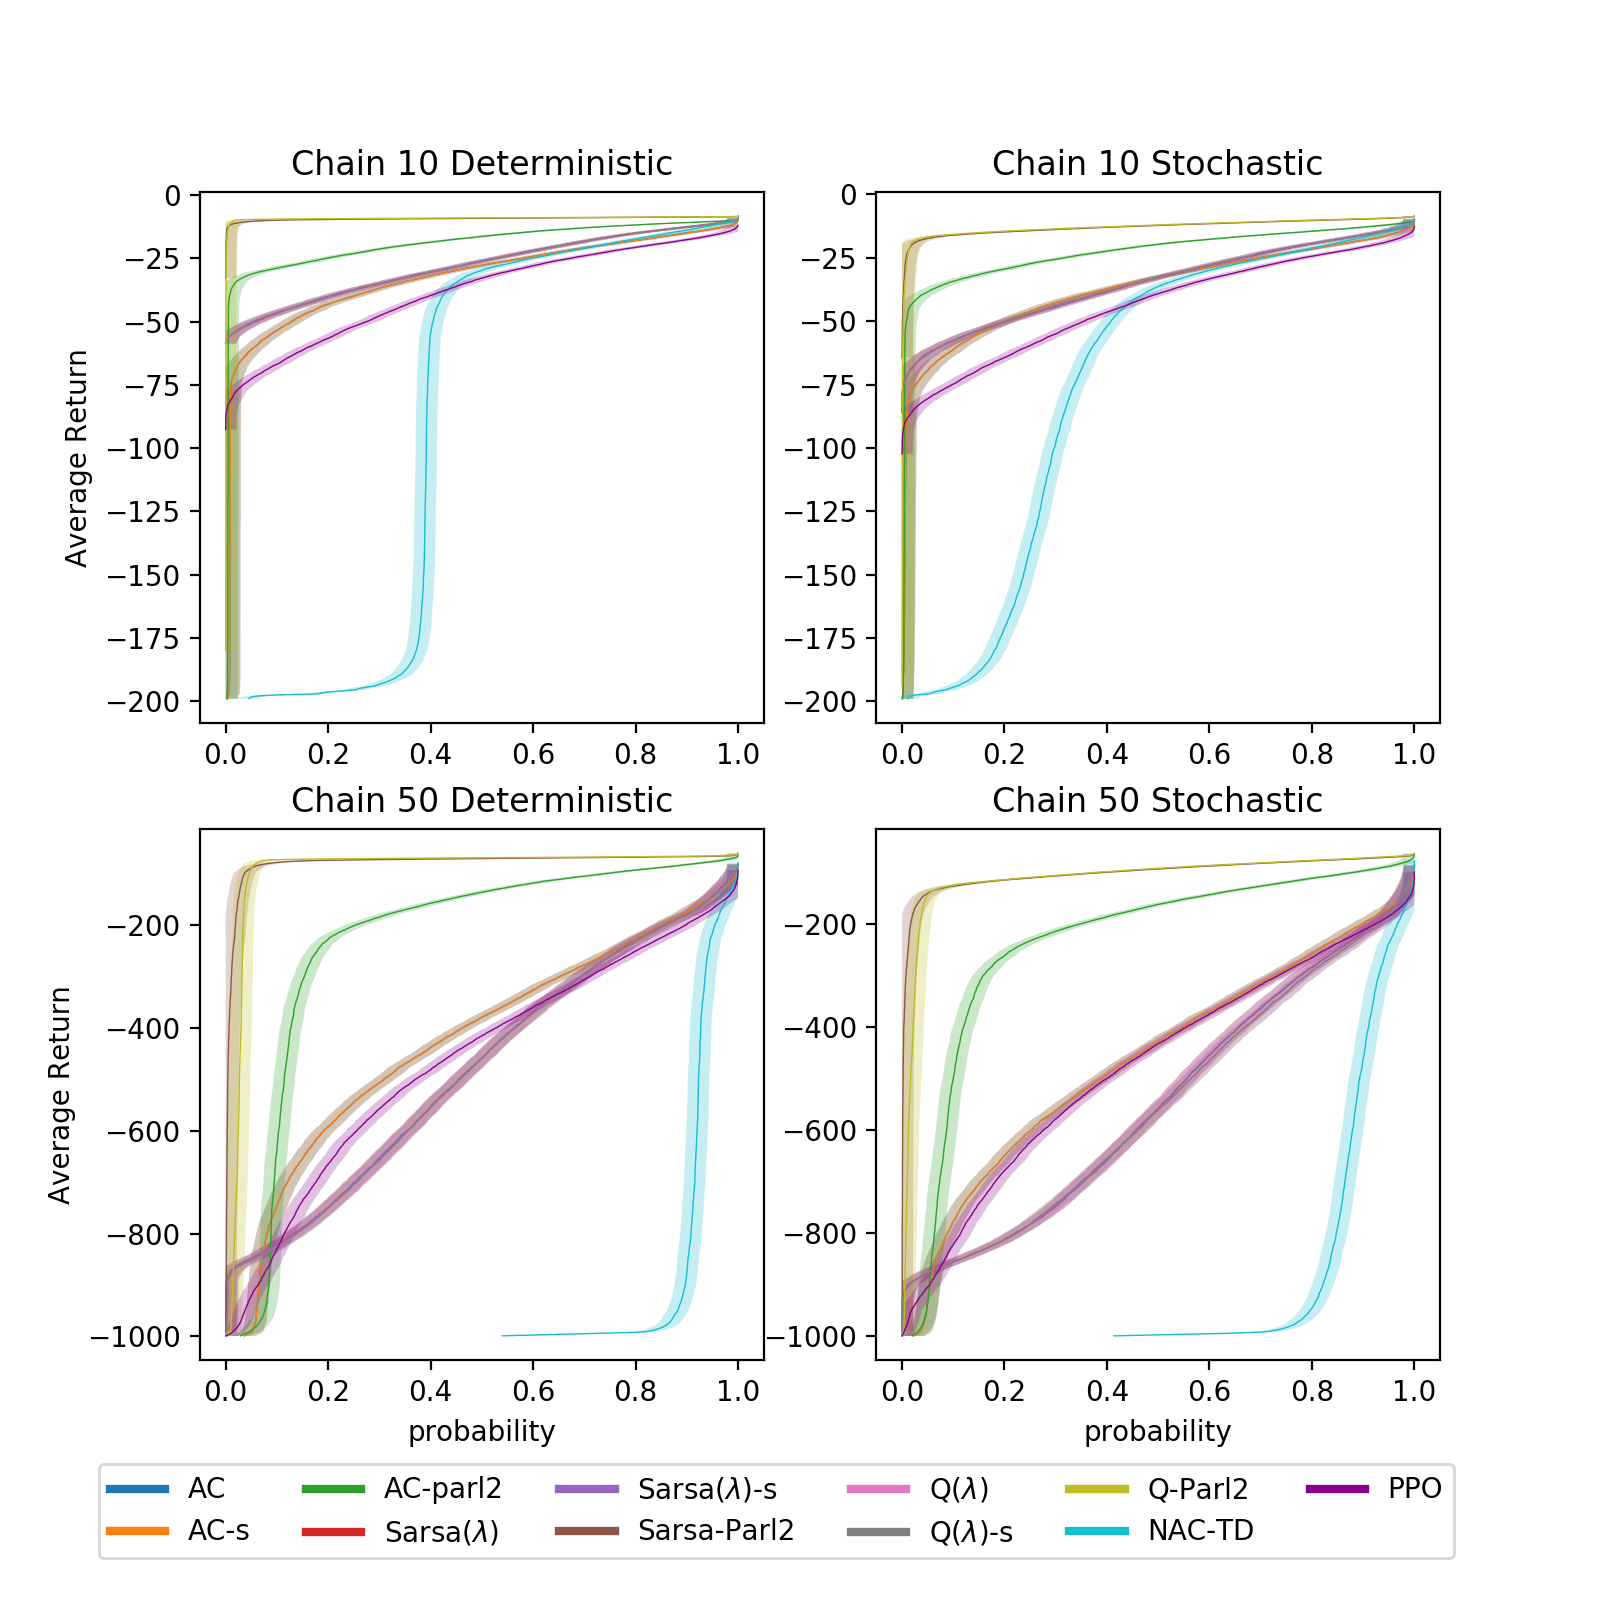

<IPython.core.display.Javascript object>


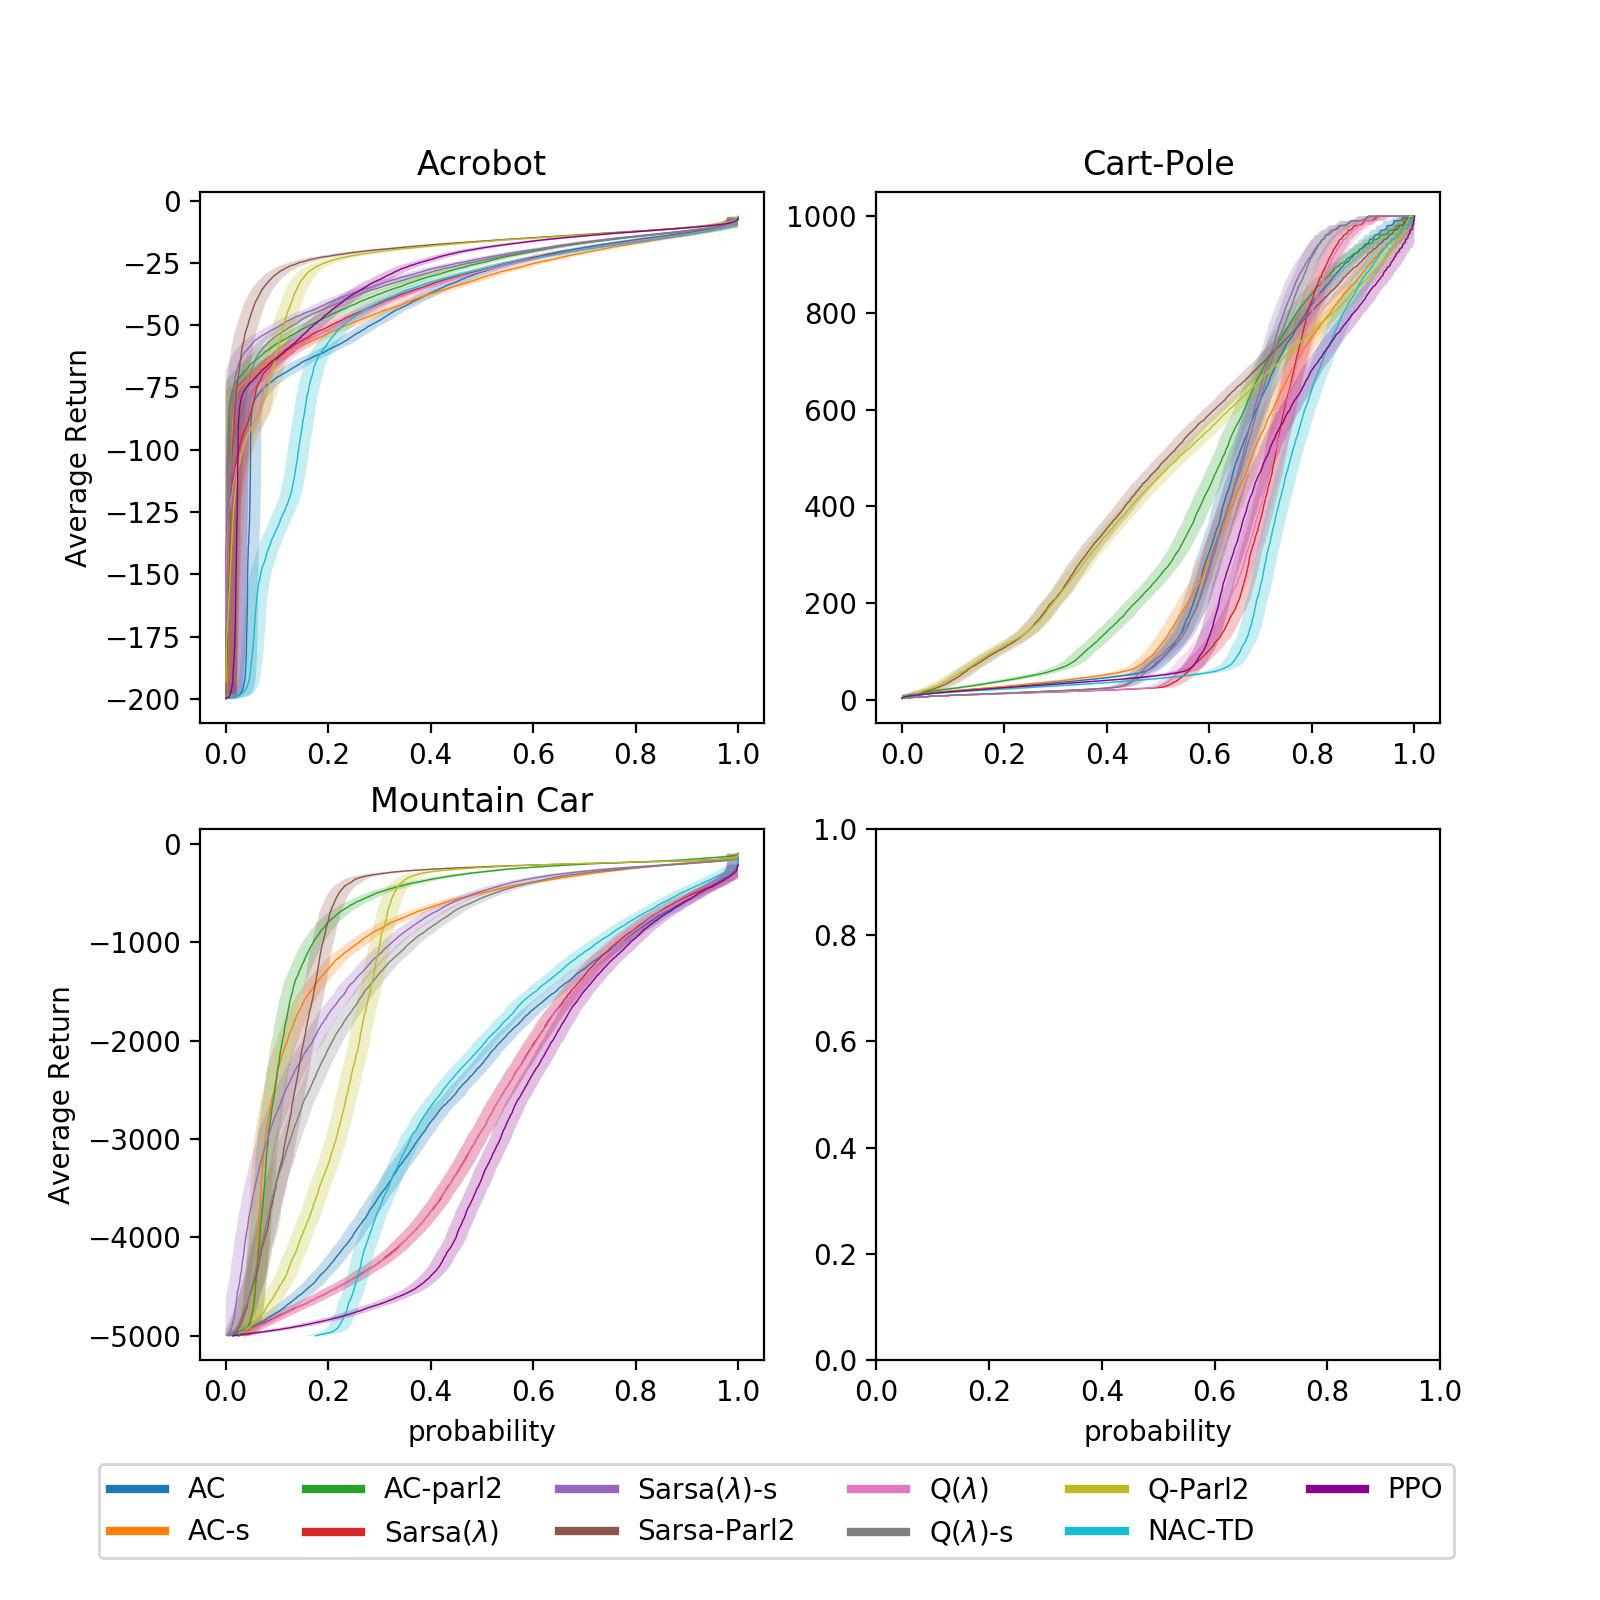

<IPython.core.display.Javascript object>


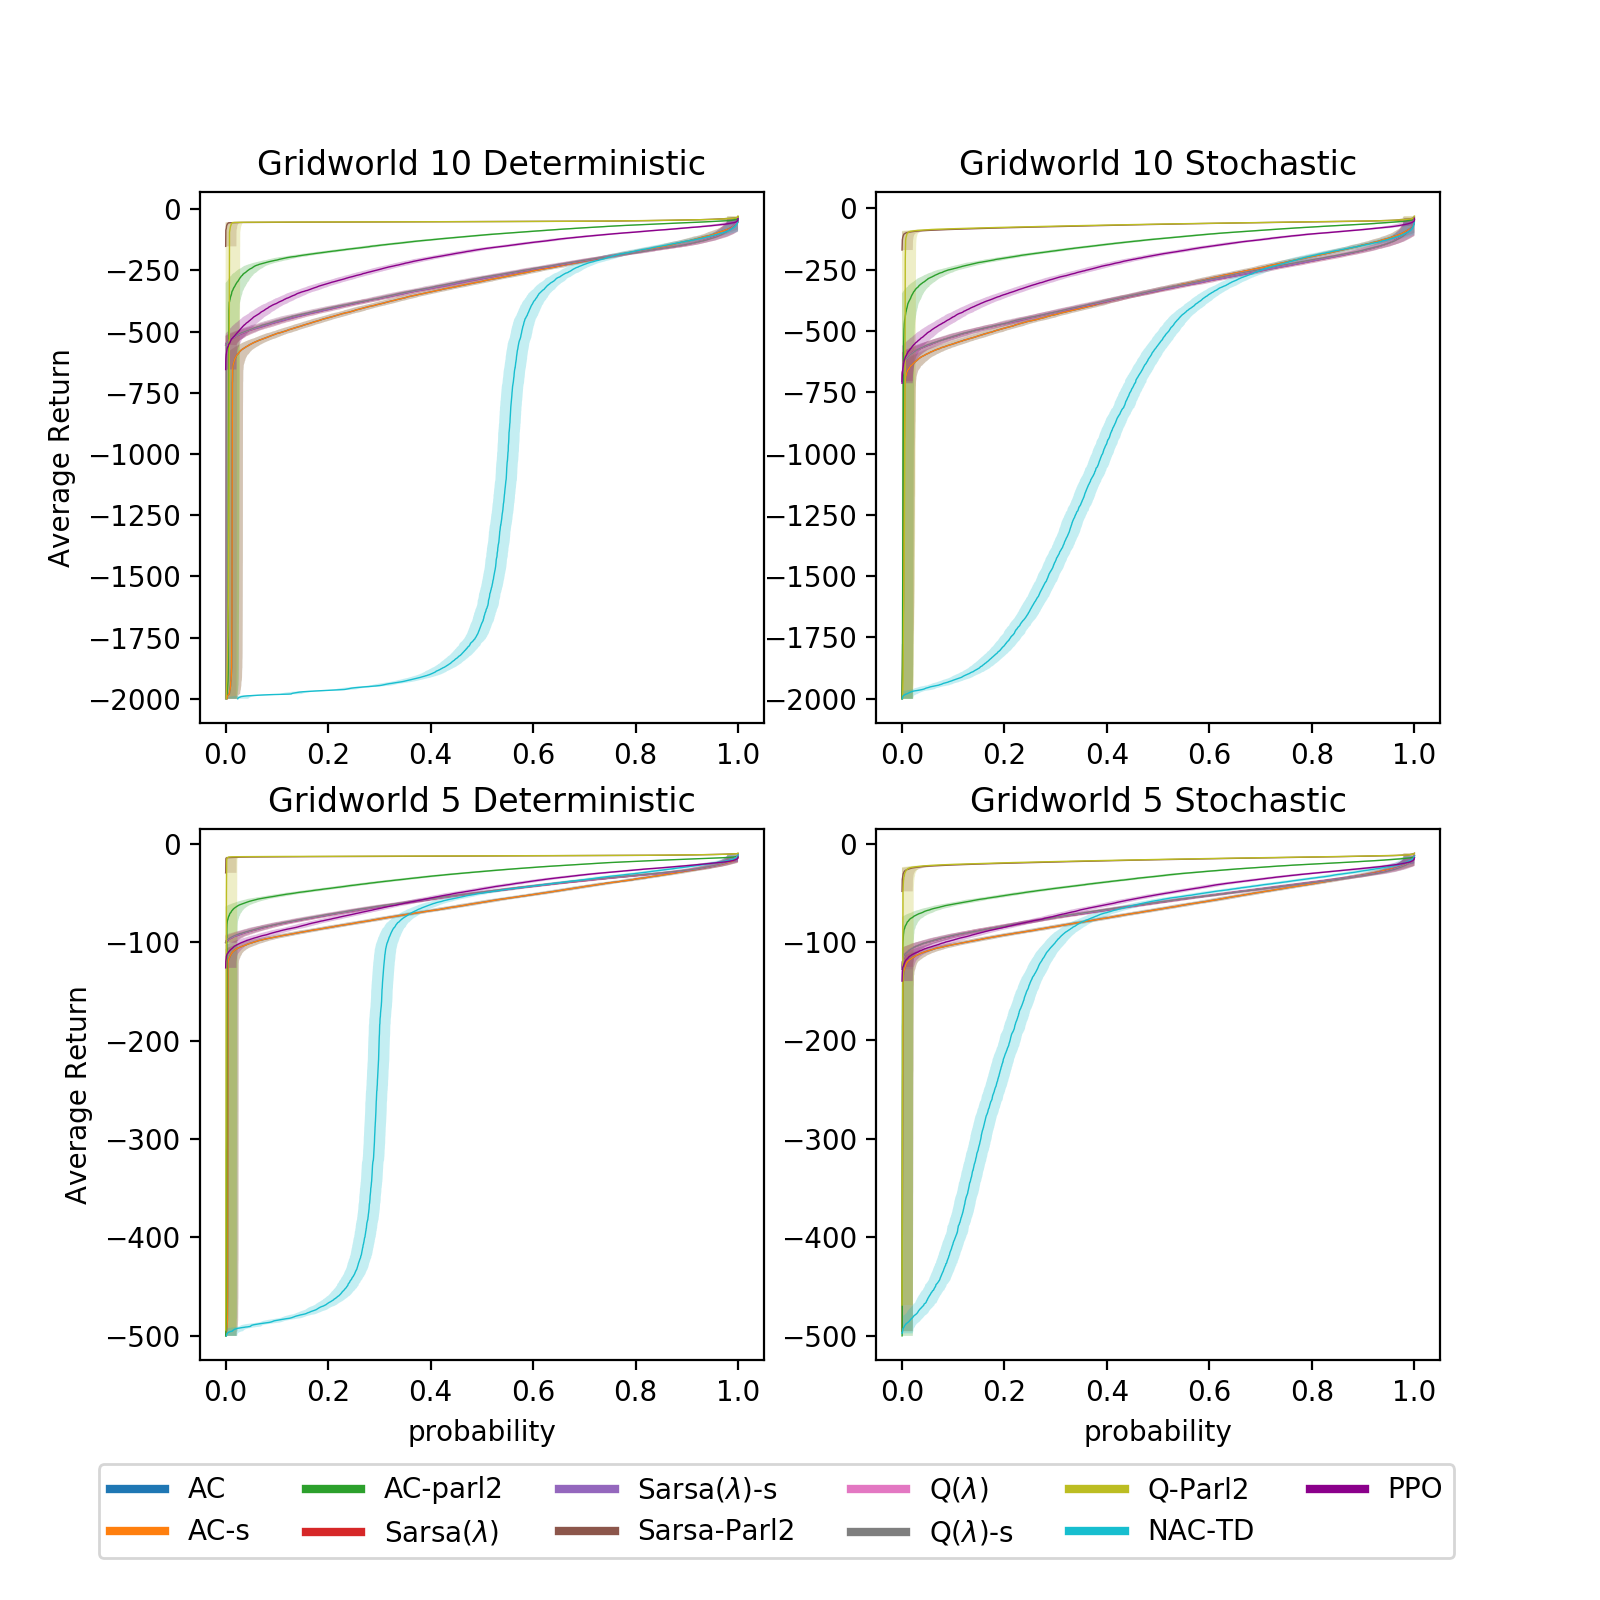

<IPython.core.display.Javascript object>


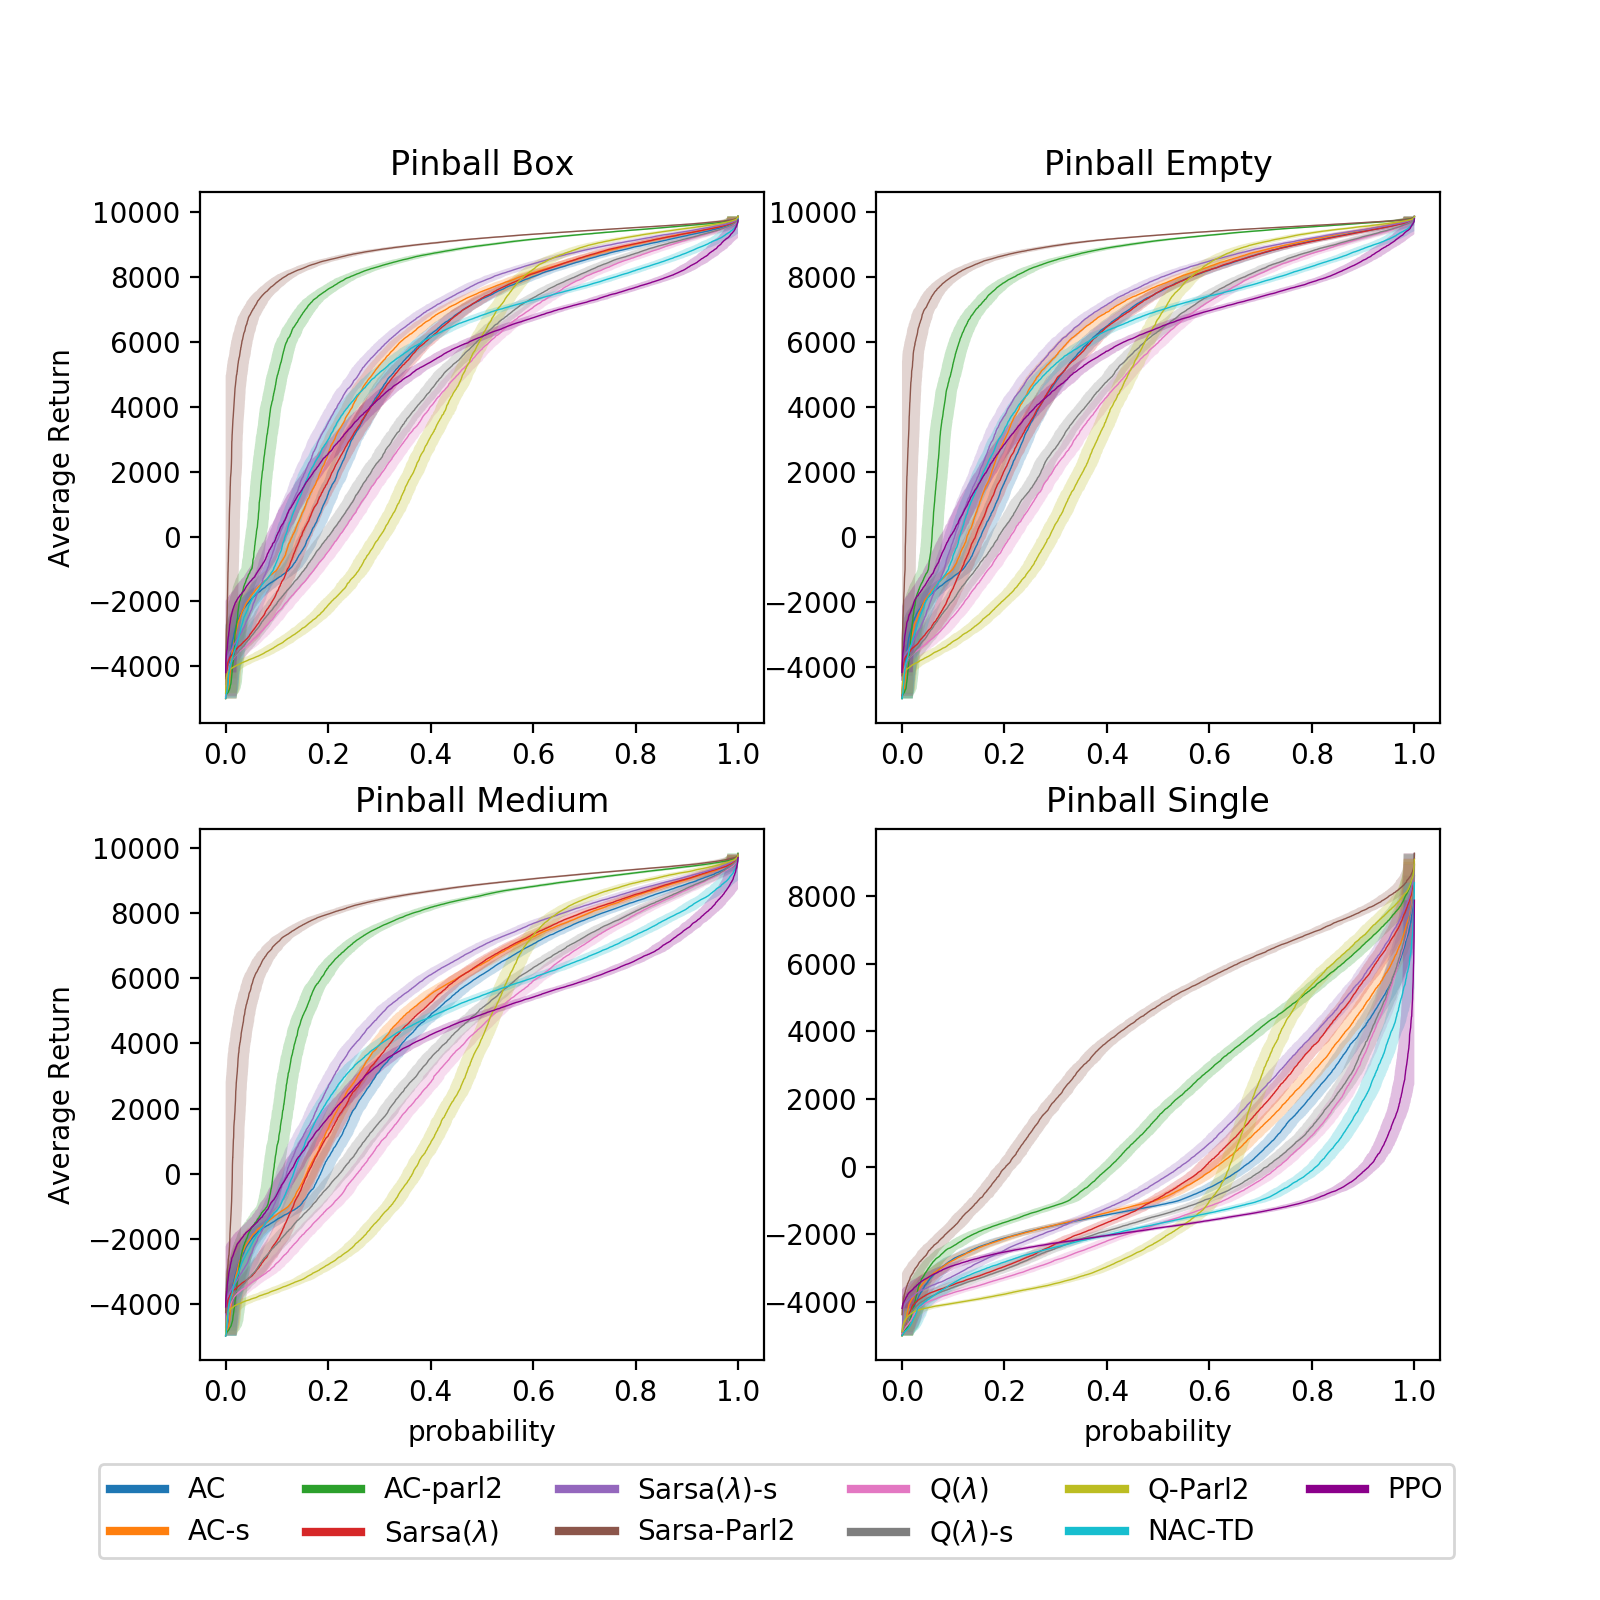

In [56]:
# plots distributions grouped by environments
plotallinvCDF2(stats, cenvs, algs, cenames, anames, ylabel="Average Return", title="Chain Environments", save=False) 
plotallinvCDF2(stats, ccenvs, algs, ccenames, anames, ylabel="Average Return", title="Classic Control Environments", save=False) 
plotallinvCDF2(stats, genvs, algs, genames, anames, ylabel="Average Return", title="Gridworld Environments", save=False) 
plotallinvCDF2(stats, penvs, algs, penames, anames, ylabel="Average Return", title="PinBall Environments", save=False) 

In [50]:
# envs = ["acrobot_d", "cartpole_d", "mntcar_d",
#         "chain10d", "chain10s", 
#         "chain50d", "chain50s", 
#         "gw10d", "gw10s", "gw5d", "gw5s", 
#         "pbbox", "pbempt", "pbmed", "pbsingle",
# ]
salgs = ['sarsa-parl2', 'sarsa-normal', 'ac-normal']
sanames = [r'Sarsa-Parl2', r"Sarsa($\lambda$)", r'Actor-Critic']

<IPython.core.display.Javascript object>


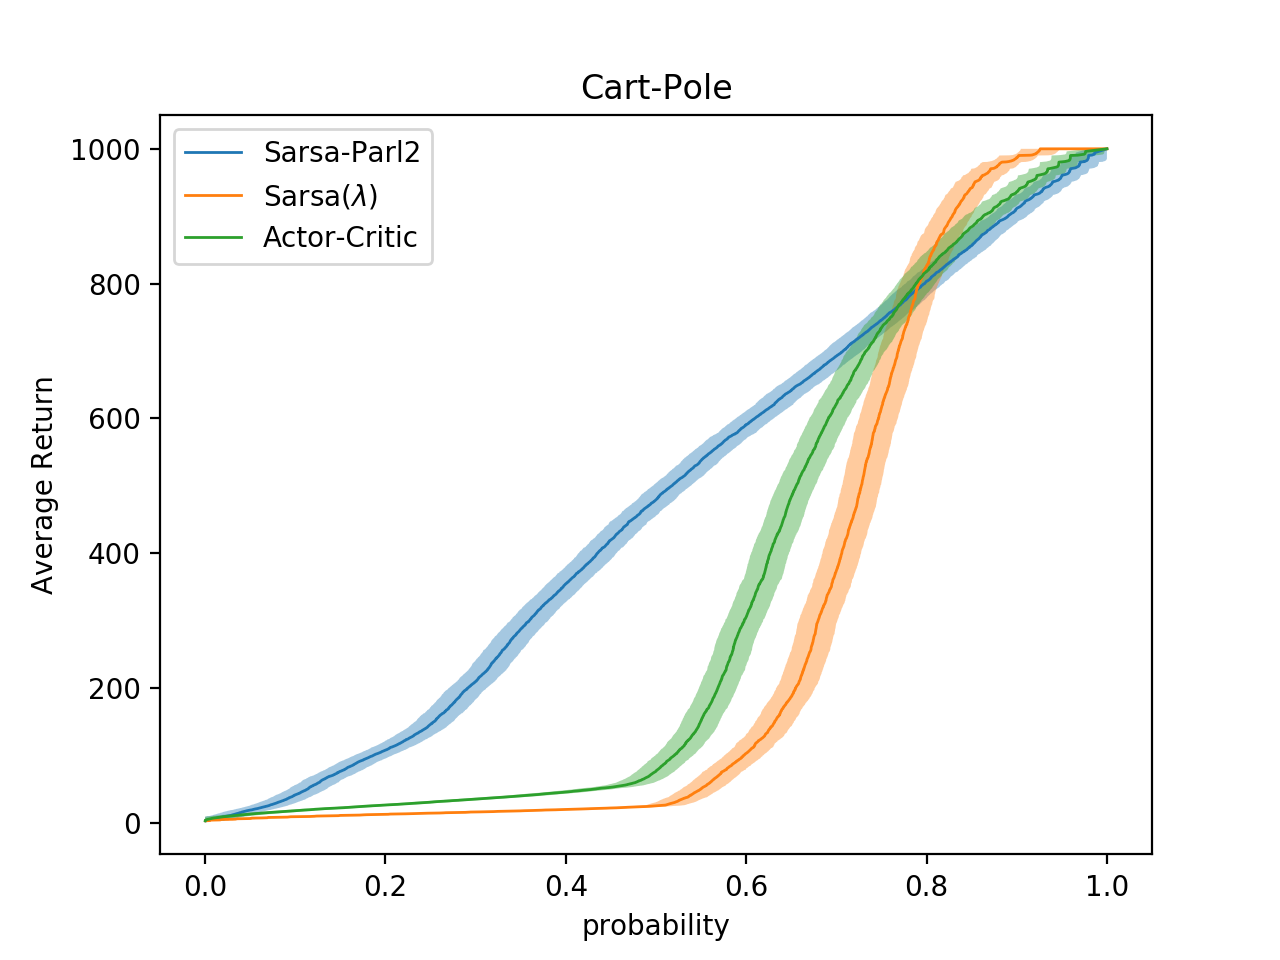

<IPython.core.display.Javascript object>


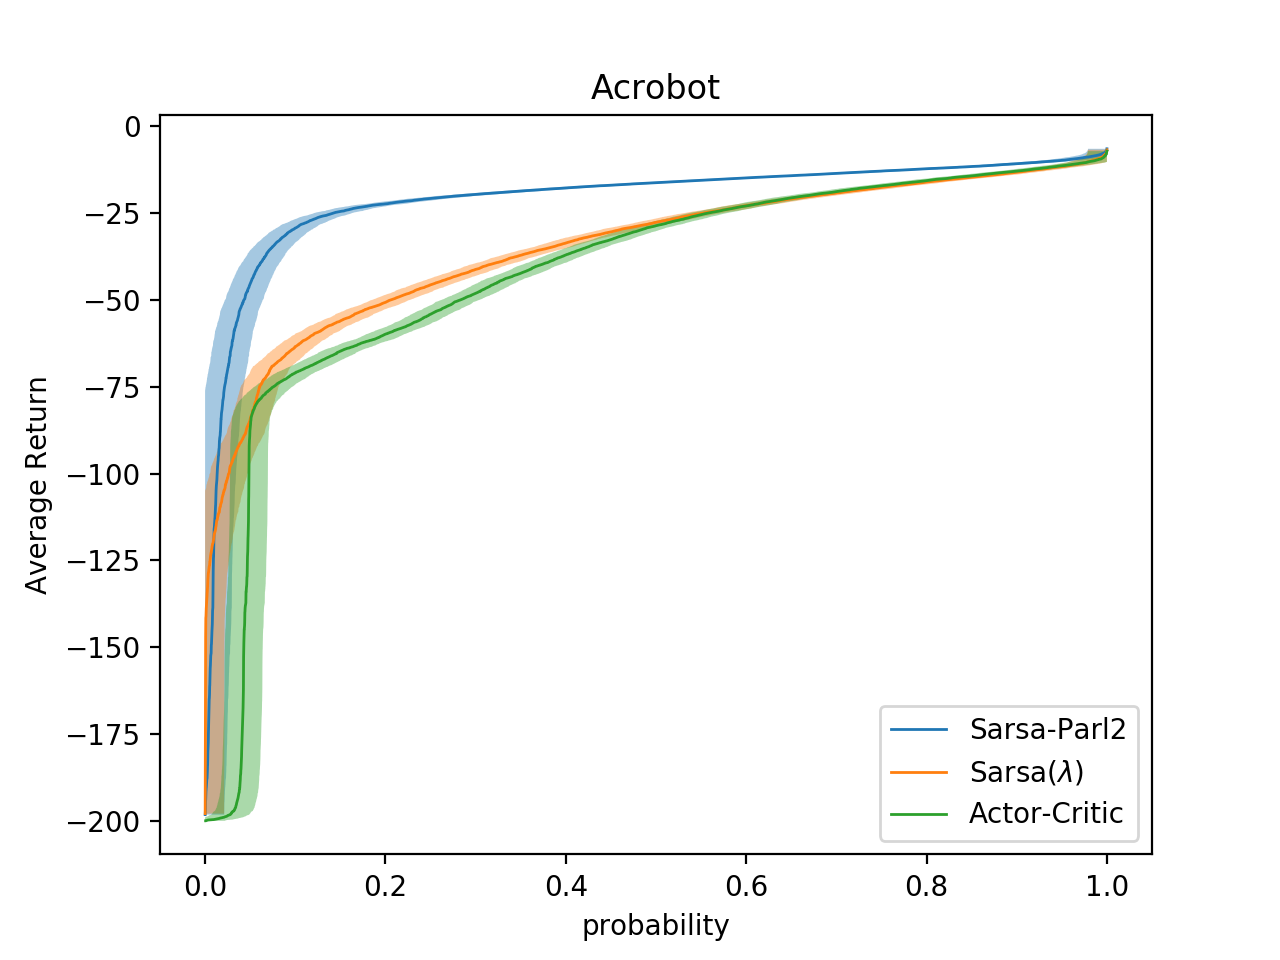

In [51]:
plotallinvCDF(stats, ['cartpole_d', 'acrobot_d'], salgs, ["Cart-Pole", "Acrobot"], sanames, ylabel="Average Return", base_fname="dist_perf_", save=False) 

<IPython.core.display.Javascript object>


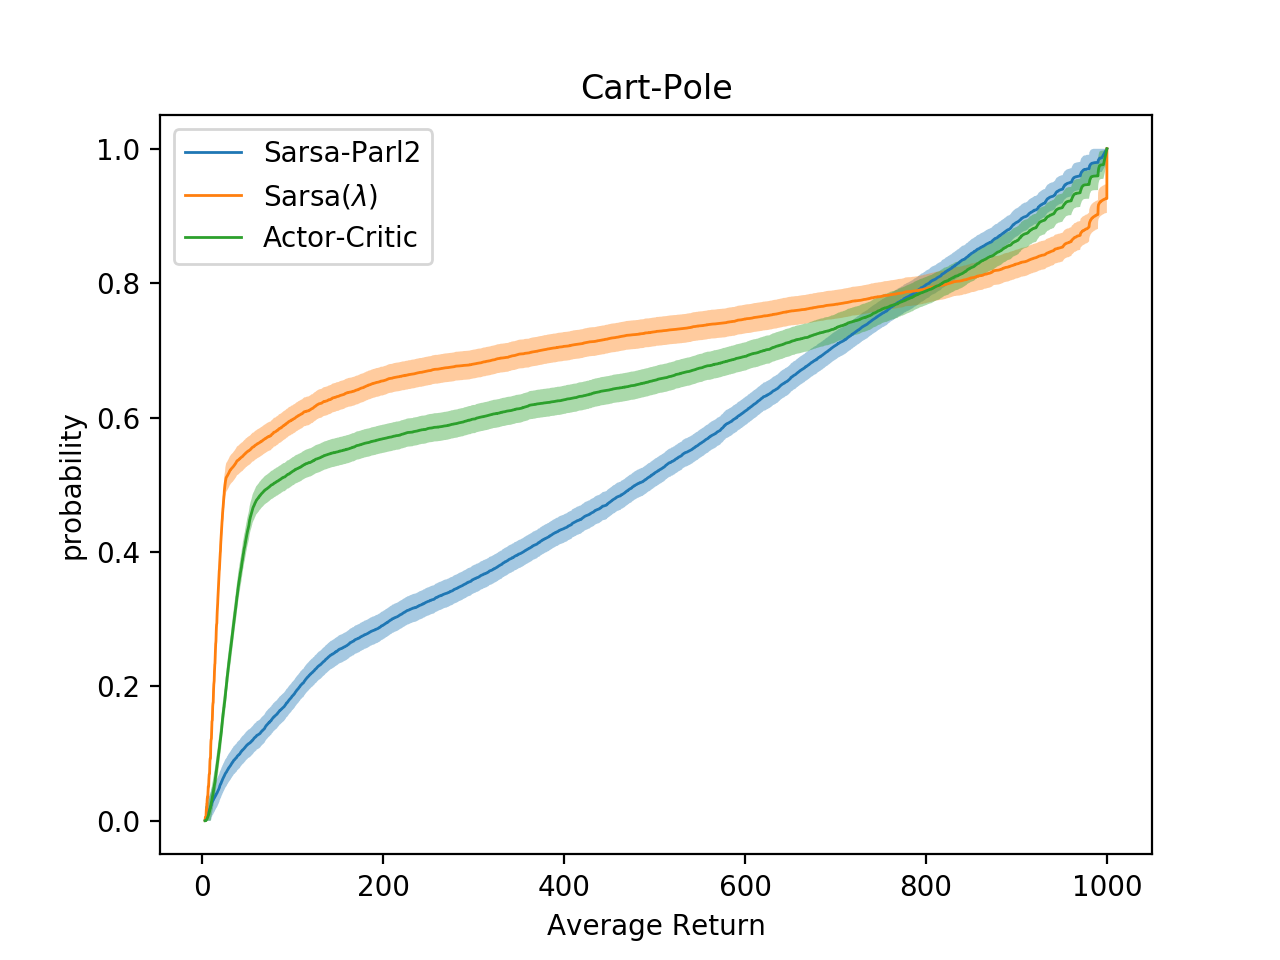

<IPython.core.display.Javascript object>


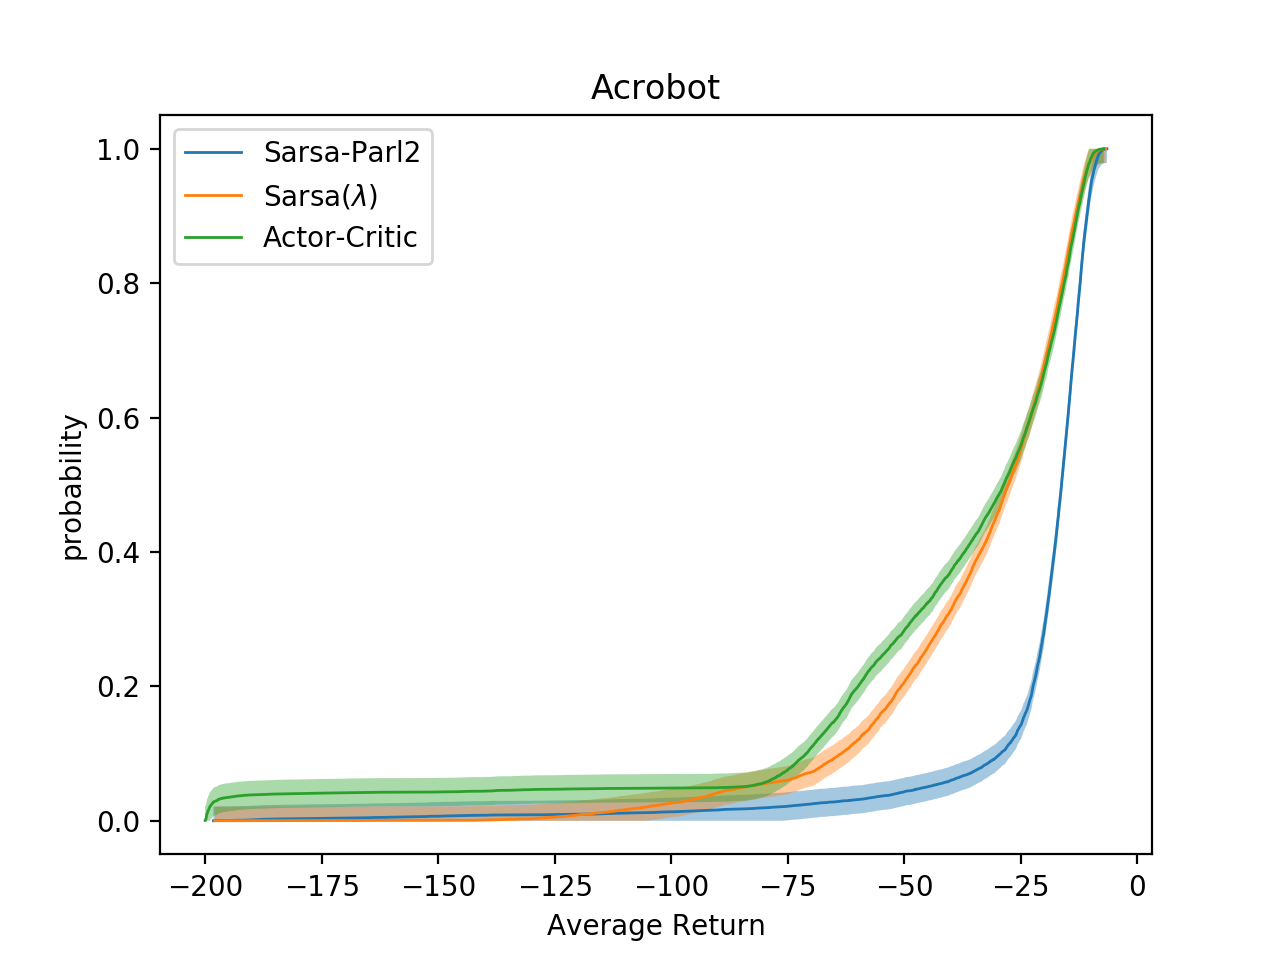

In [52]:
plotallCDF(stats, ['cartpole_d', 'acrobot_d'], salgs, ["Cart-Pole", "Acrobot"], sanames, ylabel="Average Return", base_fname="dist_perf_", save=False) 

In [53]:
# from https://stackoverflow.com/questions/31544489/two-line-styles-in-legend

class HandlerDashedLines(HandlerLineCollection):
    """
    Custom Handler for LineCollection instances.
    """
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = ((height) / (numlines + 1)) * np.ones(xdata.shape, float)
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                mcolor = orig_handle.get_facecolors()[i]
            except IndexError:
                mcolor = orig_handle.get_facecolors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] != None:
                legline.set_dashes(dashes[1])
#             legline.set_color("w")
            legline.set_markerfacecolor(mcolor)
            legline.set_marker("o")
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

In [54]:
def plot_cdfnormalized(stats, xpts, algs, env, anames, title, fname, save=False):
    fig, ax = plt.subplots()
    # colors = ["#1b9e77", "#D95F02", "#7570B3"] 
    # colors = ["#E6AB02", "#A6761D" , "#666666"] 
    # colors = ["#E6AB02", "dodgerblue" , "#666666"]
    colors = ["darkorange", "dodgerblue" , "#666666"]
    # colors = ["dodgerblue", "#E6AB02",  "#666666"] 
    # colors = ["dodgerblue", "darkorange", "forestgreen"] # darkred
    # colors = ["darkorange", "dodgerblue", "darkmagenta"] # darkred
    # colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + ["darkmagenta"]
    ax.set_prop_cycle('color', colors)
    ax.vlines(-20, -0.5,1.5, linestyle="dashed")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-150, 1050)
    xidx = 2
    for i in range(len(algs)):
        nf = stats[env][algs[i]]['cdf_fn']
        ypts = nf(np.copy(xpts))
        xipts = np.zeros_like(xpts)-30*(3-i)-20
        ax.scatter(xipts, ypts, s=25, color=colors[i], alpha=1.0, zorder=2)
        ax.vlines(xpts[xidx], 0, ypts[xidx], color="black", linestyle="dotted", linewidth=1, alpha=0.7, zorder=1)
        ax.hlines(ypts[xidx], xipts[xidx], xpts[xidx], color="black", linestyle="dotted", linewidth=1, alpha=0.7, zorder=1)
        
    for i in range(len(algs)):
        nf = stats[env][algs[i]]['cdf_fn']
        x = stats[env][algs[i]]['cdf_x']
        mid = stats[env][algs[i]]['cdf']
        low = stats[env][algs[i]]['cdf_low']
        high = stats[env][algs[i]]['cdf_high']
        
        ax.plot(x, mid, linewidth=1., color=colors[i])
        ax.fill_between(x, low, high, alpha=0.4, color=colors[i])
    ax.scatter(xpts, np.zeros_like(xpts), color="black", s=25)
    line = [[(0, 0)]]
    lc1 = Line2D([0], [0], linestyle="solid", color=colors[0], label=anames[0])
    lc2 = Line2D([0], [0], linestyle="solid", color=colors[1], label=anames[1])
    lc3 = Line2D([0], [0], linestyle="solid", color=colors[2], label=anames[2])
    lc4 = Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label="samples")
    lc51 = Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0])
    lc52 = Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1])
    lc53 = Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[2])
    labels = anames + ["samples", "normalized"]
    ax.legend([lc1, lc2, lc3, lc4, (lc51,lc52,lc53)], labels,
              handler_map={tuple: HandlerTuple(ndivide=None)}, handlelength = 2.0,
               loc='lower right', ncol=1, bbox_to_anchor=(1.00, 0.1), fancybox=False, numpoints=1, scatterpoints=1) 

    ax.set_xlabel("Average Return")
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    if save:
        pp = PdfPages("cdf_"+fname+'.pdf')
        pp.savefig(fig)
        pp.close()
#     plt.close(fig)

<IPython.core.display.Javascript object>


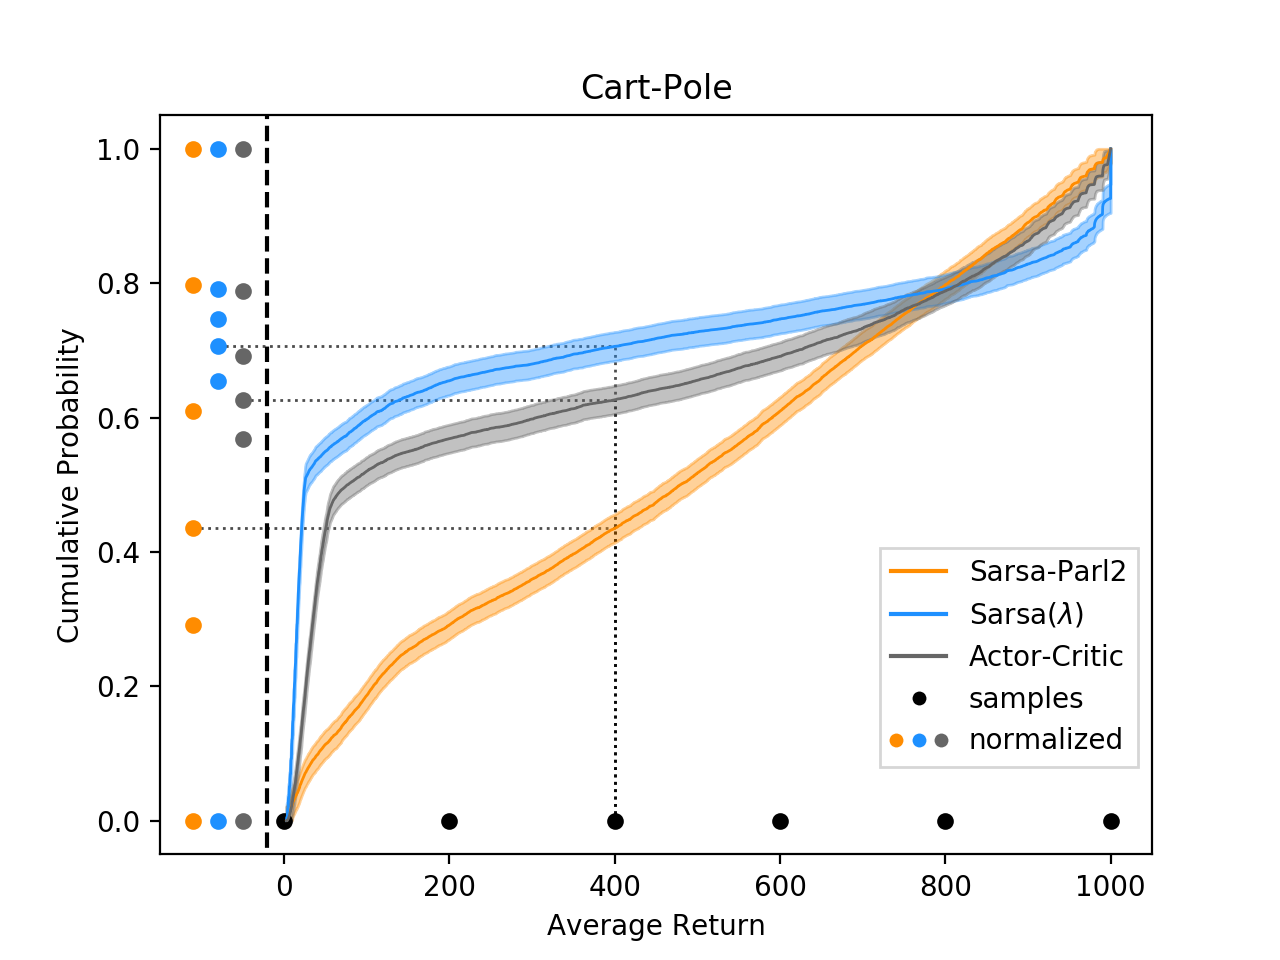

In [55]:
plot_cdfnormalized(stats, np.arange(0,1010,step=200), salgs, 'cartpole_d', sanames, r"Cart-Pole", "cartpole_normalizedpts")

### $\LaTeX$ Performance table creation

Code below outputs $\LaTeX$ to show performance and ranking of each algorithm on each environment


In [58]:
def compute_rank(score, lows, highs):
    N = len(score)
    rank = np.zeros(N, dtype=np.int64)
    rank_low = np.zeros(N, dtype=np.int64)
    rank_high = np.zeros(N, dtype=np.int64)
    
    for i in range(N):
        rank[i] = (N+1) - np.count_nonzero(score[i] >= score)
        rank_low[i] = max((N+1) - np.count_nonzero(lows[i] > highs), 1) - 1
        rank_high[i] = (N+1) - np.count_nonzero(highs[i] > lows)
    
    return rank, rank_low, rank_high
    
def make_envtable1(stats, algs, anames):
    mns, lows, highs= [], [], []
    
    for alg in algs:
        mns.append(stats[alg]['mean'])
        lows.append(stats[alg]['mean_low'])
        highs.append(stats[alg]['mean_high'])
    
    r, rlow, rhigh = compute_rank(mns, lows, highs)
    df = pd.DataFrame({"Algorithm": anames, "perf": mns, "perf_low": lows, "perf_high": highs,
                       "rank": r, "rank_low": rlow, "rank_high": rhigh
                      }, index=anames)
    return df

def make_papertable(df):
    idxs = df.index
    perfs = []
    ranks = []
    for idx in idxs:
        mn, lw, hh = df.loc[idx, ["perf", "perf_low", "perf_high"]].values
        perfs.append("{0:.1f} ({1:1<.1f}, {2:.1f})".format(mn, lw, hh)  )
        r, rl, rh = df.loc[idx, ["rank", "rank_low", "rank_high"]].values.astype(np.int)
        ranks.append("{0:2d} ({1:d}, {2:d})".format(r, rl, rh))
    pdf = pd.DataFrame({"Algorithm": idxs, "Mean": perfs, "Rank": ranks}, index=idxs)
    return pdf

def make_latex(df, title, label):
    tex = df.to_latex(escape=False, column_format='lcr', index=False)
    idx = tex.index("\\toprule\n")
    l=len("\\toprule\n")
    ptex = tex[:idx+l]
    ntex = tex[idx+l:]
    mytex = "\\multicolumn{3}{c}{\\textbf{%s}}                      \\\\ \n\\midrule \n" % title
    tex2 = ptex+mytex+ntex
    lines = tex2.split('\n')
    
    final_lines = ["\\begin{table}[] ", "\\centering "] + lines[:6]
    colored = False
    for line in lines[6:-2]:
        if colored == False: 
            final_lines.append("\\rowcolor[HTML]{EFEFEF} ")
            colored = True
        else:
            colored = False
        final_lines.append(line)
    final_lines.append(lines[-2])
    final_lines.append("%\\caption{}")
    final_lines.append("\\label{tab:perf_%s}" % label)
    final_lines.append("\\end{table}")
    final_tex = '\n'.join(final_lines)
    return final_tex

def build_table_string(stats, envs, algs, enames, anames, elabels):
    seperator = "\n\n%" + "".join(["-"]*50) + "\n\n"
    alltex = []
    for env, ename, elabel in zip(envs, enames, elabels):
        tex = make_latex(make_papertable(make_envtable1(stats[env], algs, anames).sort_values("rank")), ename, elabel)
        alltex.append(tex)
        alltex.append(seperator)
    res = "\n".join(alltex)
    return res
    

In [59]:
elabels = ['acrobot','cartpole', 'mntcar', 'chain10d', 'chain10s','chain50d', 'chain50s','gw10d', 'gw10s', 'gw5d', 'gw5s','pbbox', 'pbempt','pbmed','pbsingle']
tex = build_table_string(stats, envs, algs, enames, anames, elabels)

In [60]:
# show Tex
print(tex)

\begin{table}[] 
\centering 
\begin{tabular}{lcr}
\toprule
\multicolumn{3}{c}{\textbf{Acrobot}}                      \\ 
\midrule 
          Algorithm &                  Mean &         Rank \\
\midrule
\rowcolor[HTML]{EFEFEF} 
        Sarsa-Parl2 &  -20.6 (-24.6, -18.1) &     1 (2, 1) \\
            Q-Parl2 &  -25.7 (-29.8, -22.8) &     2 (6, 1) \\
\rowcolor[HTML]{EFEFEF} 
 Sarsa($\lambda$)-s &  -28.3 (-32.3, -26.3) &     3 (6, 2) \\
     Q($\lambda$)-s &  -30.3 (-34.3, -27.9) &     4 (9, 2) \\
\rowcolor[HTML]{EFEFEF} 
                PPO &  -30.5 (-34.5, -26.7) &     5 (9, 2) \\
           AC-parl2 &  -30.6 (-34.6, -28.8) &     6 (9, 2) \\
\rowcolor[HTML]{EFEFEF} 
   Sarsa($\lambda$) &  -34.7 (-38.7, -32.4) &    7 (10, 4) \\
       Q($\lambda$) &  -35.7 (-39.7, -33.3) &    8 (10, 4) \\
\rowcolor[HTML]{EFEFEF} 
               AC-s &  -36.0 (-40.0, -33.5) &    9 (10, 4) \\
                 AC &  -41.4 (-45.4, -37.3) &   10 (11, 7) \\
\rowcolor[HTML]{EFEFEF} 
             NAC-TD &  -47.1